# Analyzing Cryptocurrency Market Trends: Unveiling Patterns and Predicting the Future
## By: Hasnain Shahzad (hs1063)

In [1]:
import pandas as pd
import mysql.connector
import numpy as np
import matplotlib.pyplot as plt
import warnings

Filters wanring messages

In [2]:
warnings.filterwarnings('ignore', message="pandas only supports SQLAlchemy connectable")

Configuration to log into mySQL

In [3]:
db_config = {
    'host': 'localhost',
    'user': 'root', #Chnage to the name of your username
    'password': 'Hasnain123', #Chnage to the name of your password
    'database': 'crypto_db'
}
# Part 1: Database/Table Creation 

Step 1: Create Database and Table

In [4]:
def create_database_and_table():
    # Step 1: Load the CSV into a Pandas DataFrame
    csv_file = "BTC_7D_graph_coinmarketcap.csv"  # Replace with your CSV file name or path
    df = pd.read_csv(csv_file, delimiter=';')
    df = df[df['marketCap'] > 0] 
    df['marketCap'] = df['marketCap'].replace(0, df['marketCap'].median()) 
    df.columns = ['name', 'open', 'high', 'low', 'close', 'volume', 'marketCap', 'timestamp']
    return df

Step 2: Preprocess the DataFrame

In [5]:
# Call the function to create and load the DataFrame
df = create_database_and_table()

Convert timestamp to a readable format

In [6]:
    df['timestamp'] = pd.to_datetime(df['timestamp'], errors='coerce')  # Convert to datetime
    df['timestamp'] = df['timestamp'].dt.strftime('%b %d %Y, %H:%M') 

Convert numeric columns to appropriate types

In [7]:
    numeric_columns = ['open', 'high', 'low', 'close', 'volume', 'marketCap']
    df[numeric_columns] = df[numeric_columns].apply(pd.to_numeric, errors='coerce')
    df[numeric_columns] = df[numeric_columns].round(3)
    df = df.where(pd.notnull(df), None)

Step 3: Database connection details

In [8]:
    conn = mysql.connector.connect(**db_config)
    cursor = conn.cursor()

Drop the table if it exists

In [9]:
    cursor.execute("DROP TABLE IF EXISTS cryptocurrency_data")

Step 4: Create a table dynamically based on the DataFrame

In [10]:
    table_name = "cryptocurrency_data"
    columns = ", ".join([
        "`name` TEXT",
        "`open` DECIMAL(10, 3)",
        "`high` DECIMAL(10, 3)",
        "`low` DECIMAL(10, 3)",
        "`close` DECIMAL(10, 3)",
        "`volume` DECIMAL(15, 3)",
        "`marketCap` DECIMAL(20, 3)",
        "`timestamp` TEXT"  # Use TEXT to store formatted string
    ])
    create_table_query = f"CREATE TABLE IF NOT EXISTS {table_name} ({columns})"
    cursor.execute(create_table_query)

Step 5: Insert data into the table

In [11]:
insert_query = f"""
INSERT INTO {table_name} ({', '.join([f'`{col}`' for col in df.columns])})
VALUES ({', '.join(['%s'] * len(df.columns))})
"""
cursor.executemany(insert_query, df.values.tolist())
conn.commit()

print(f"Data successfully inserted into table `{table_name}`.")


Data successfully inserted into table `cryptocurrency_data`.


Part 2: Visualize Price Movements

This Function plots the points of the closing value of the crypto and places it onto a line graph.

In [12]:
def plot_price_movement():
    conn = mysql.connector.connect(**db_config)
    query = "SELECT `name`, `open`, `close`, `timestamp` FROM cryptocurrency_data"
    df = pd.read_sql(query, conn)
    df['timestamp'] = pd.to_datetime(df['timestamp'], format='%b %d %Y, %H:%M')
    fig, ax = plt.subplots(figsize=(10, 6))
    for label, grp in df.groupby('name'):
        ax.plot(grp['timestamp'], grp['close'], label=label)
    ax.set_title('Cryptocurrency Price Movement')
    ax.set_xlabel('Date')
    ax.set_ylabel('Closing Price')
    ax.legend(title='Cryptocurrency')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    conn.close()

This Function plots the market cap of the crypto each day onto a line graph.

In [13]:
def plot_market_cap():
    conn = mysql.connector.connect(**db_config)
    query = "SELECT `name`, `marketCap`, `timestamp` FROM cryptocurrency_data"
    df = pd.read_sql(query, conn)
    
    df['timestamp'] = pd.to_datetime(df['timestamp'], format='%b %d %Y, %H:%M')
    fig, ax = plt.subplots(figsize=(12, 8))
    for label, grp in df.groupby('name'):
        ax.plot(grp['timestamp'], grp['marketCap'], label=label, marker='o')
    ax.set_title('Market Capitalization Over Time')
    ax.set_xlabel('Date')
    ax.set_ylabel('Market Capitalization')
    ax.legend(title='Cryptocurrency')
    plt.xticks(rotation=45)
    plt.yscale('linear')  # Set the scale of the y-axis to linear
    plt.tight_layout()
    plt.show()
    conn.close()

Part 3 Analysis

This function calculates the mean growth of the crypto.

In [14]:
def calculate_mean_growth():
    conn = mysql.connector.connect(**db_config)
    query = "SELECT `open`, `close` FROM cryptocurrency_data"
    df = pd.read_sql(query, conn)
    df['growth'] = df['close'] - df['open']
    mean_growth = df['growth'].mean()
    conn.close()
    print(f"Mean Growth: {mean_growth:.3f}")
    
# This function calculates the absolute error for the crypto.
def calculate_absolute_error():
    conn = mysql.connector.connect(**db_config)
    query = "SELECT `open`, `close` FROM cryptocurrency_data"
    df = pd.read_sql(query, conn)
    df['abs_growth_error'] = (df['close'] - df['open']).abs()
    mae_growth = df['abs_growth_error'].mean()
    conn.close()
    print(f"Mean Absolute Error of Growth: {mae_growth:.3f}")

In [15]:
def perform_linear_regression():
    # Connect to the database
    conn = mysql.connector.connect(**db_config)
    query = "SELECT `name`, `open`, `close` FROM cryptocurrency_data"
    df = pd.read_sql(query, conn)
    results = {}
    
    for name, group in df.groupby('name'):
        # Fit the linear regression model
        slope, intercept = np.polyfit(group['open'], group['close'], 1)
        # Compute R-squared
        correlation_matrix = np.corrcoef(group['open'], group['close'])
        correlation_xy = correlation_matrix[0, 1]
        r_squared = correlation_xy ** 2
        
        # Store the results
        results[name] = {
            'intercept': intercept,
            'slope': slope,
            'R-squared': r_squared
        }
    conn.close()
    
    # Print the results
    print("Linear Regression Results for each Cryptocurrency:")
    for name, res in results.items():
        print(f"{name}: Intercept = {res['intercept']:.3f}, Slope = {res['slope']:.3f}, R-squared = {res['R-squared']:.3f}")
    
    return results

def interpret_linear_regression(intercept, slope, r_squared, name):
    """
    Function to interpret linear regression results.
    """
    print(f"\nInterpretation for Cryptocurrency {name}:")
    print(f"Intercept: {intercept:.3f}")
    print(f"Slope: {slope:.3f}")
    print(f"R-squared: {r_squared:.3f}")
    
    if slope > 0:
        print(f"The positive slope ({slope:.3f}) indicates an upward trend, suggesting that the cryptocurrency price increases over time.")
    elif slope < 0:
        print(f"The negative slope ({slope:.3f}) indicates a downward trend, suggesting that the cryptocurrency price decreases over time.")
    else:
        print("The slope is 0, indicating no trend in cryptocurrency prices over time.")
    
    print(f"The intercept ({intercept:.3f}) represents the estimated price of the cryptocurrency when the independent variable is 0.")
    print(f"The R-squared value ({r_squared:.3f}) indicates that the model explains approximately {r_squared * 100:.2f}% of the variation in cryptocurrency prices.")

    if r_squared > 0.8:
        print("This is a strong fit, making the model reliable for predictions.")
    elif r_squared > 0.5:
        print("This is a moderate fit, and the model can provide some insights, but predictions may not be very accurate.")
    else:
        print("This is a weak fit, and the model may not be reliable for predictions.")


Main statment for code to run: Place function you want to run into the main function.

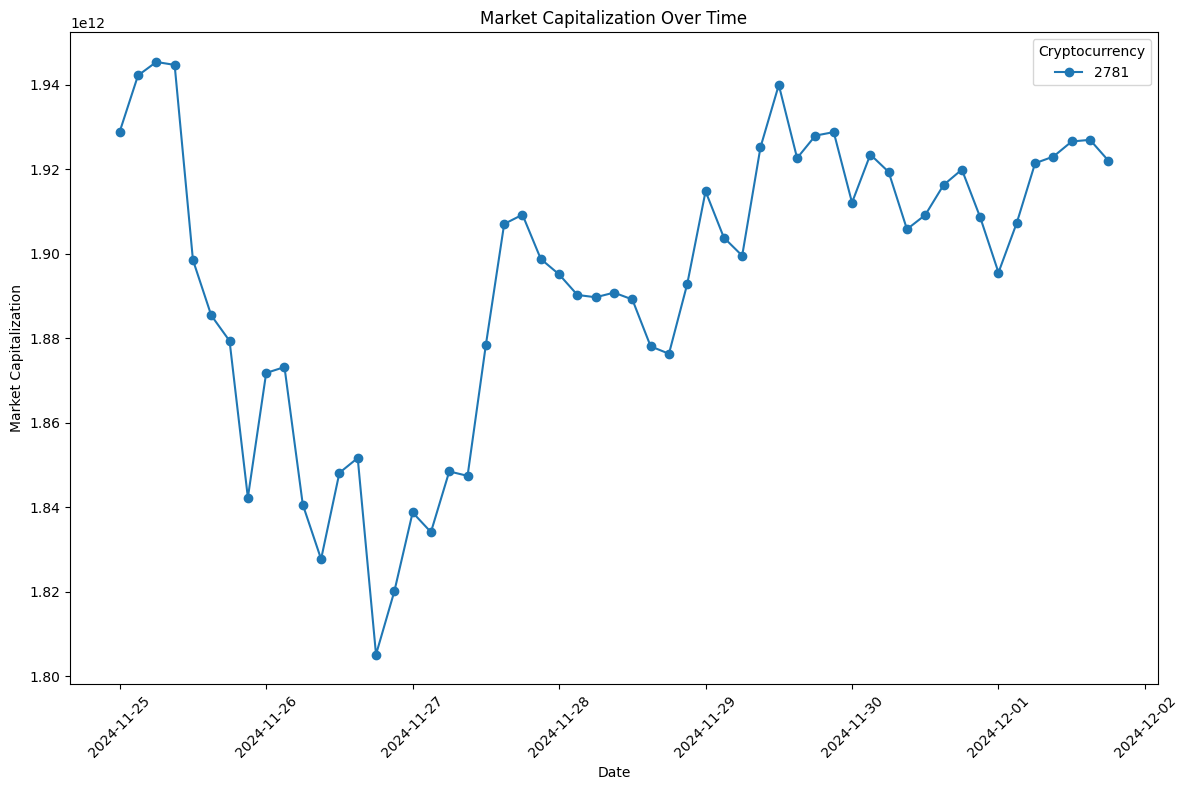

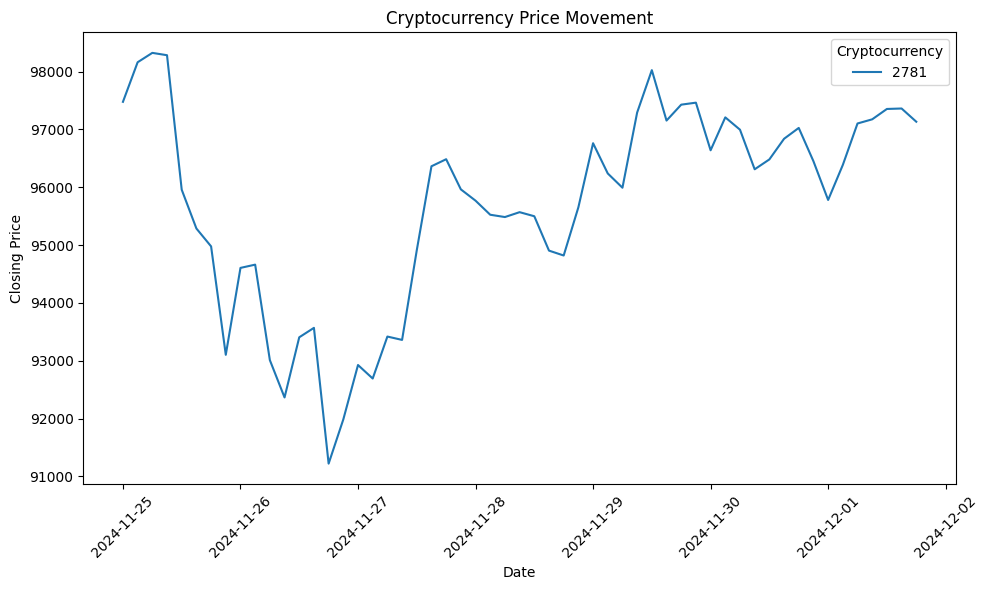

Mean Growth: -15.193
Mean Absolute Error of Growth: 612.255
Linear Regression Results for each Cryptocurrency:
2781: Intercept = 11929.915, Slope = 0.875, R-squared = 0.782

Interpretation for Cryptocurrency 2781:
Intercept: 11929.915
Slope: 0.875
R-squared: 0.782
The positive slope (0.875) indicates an upward trend, suggesting that the cryptocurrency price increases over time.
The intercept (11929.915) represents the estimated price of the cryptocurrency when the independent variable is 0.
The R-squared value (0.782) indicates that the model explains approximately 78.23% of the variation in cryptocurrency prices.
This is a moderate fit, and the model can provide some insights, but predictions may not be very accurate.


In [16]:
if __name__ == "__main__":
# Step 1: Create the database and table
    create_database_and_table()
#Step 2: Plot price movements for a specific cryptocurrency
    plot_market_cap()
    plot_price_movement()
    
# Step 3: Run Calculations
    calculate_mean_growth()
    calculate_absolute_error()
# Main Function
    results = perform_linear_regression()

# Interpret results for each cryptocurrency
    for name, res in results.items():
        interpret_linear_regression(res['intercept'], res['slope'], res['R-squared'], name)


### By analyzing these outputs, users can identify growth patterns and make data-driven predictions about future price movements and market behavior.